In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from math import floor

from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score

In [113]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [114]:
def bin_time_series(array, binsize, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
        
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
        
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else: gauss_array = array
            
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array):
    n,t = array.shape
    binary_spikes = np.zeros((n,t))
    for i in range(n):
        for j in range(t):
            if array[i][j] == 0: pass
            else: binary_spikes[i][j] = 1
    return(binary_spikes)

def threshold(array, thresh):
    n,t = array.shape
    thresholded_array = np.copy(array)
    for i in range(n):
        for j in range(t):
            if array[i][j] < thresh: thresholded_array[i][j] = 0
            else: pass
    return(thresholded_array)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def spike_count(spikes, ax, num_bins = None, t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    binary = binarize(spikes)
    for i in range(n):
        spike_count.append(np.sum(binary[i][t_min:t_max]))
    if num_bins is None: num_bins = int(np.max(spike_count) - np.min(spike_count))
    n, bins, patches = ax.hist(spike_count, num_bins, color = 'blue')
    ax.set_title("Spike Rate Distribution")
    ax.set_xlabel("Total Number of Spikes", fontsize = 22)
    ax.set_ylabel("Number of Neurons", fontsize = 22)
    return(n,bins)

In [225]:
def generate_ground_truth(comm_sizes, method = 'scattered', pad = False, community_operation = 'grow'):
    ##genertaes community labels according to two methods one in which the rest of the network except the planted communities
    # are scattered i.e. they all have their own community or they are all in one community, integrated.
    if community_operation == 'grow':
        layers = len(comm_sizes)
        if method == 'scattered':
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + list(np.arange(1, sum(comm_sizes[1:])+1))
            
            truth_labels_tip = truth_labels
                     
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + truth_labels_tip[sum(comm_sizes[:j]):]
            
            truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
            
            if pad:
                truth_labels = truth_labels_tip + truth_labels
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]  
        
        if method == 'integrated':
        
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + [1 for i in range(sum(comm_sizes[1:]))]
            if pad: truth_labels = truth_labels + truth_labels
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + [1 for i in range(sum(comm_sizes[j:]))]

            if pad:
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                
    elif community_operation == 'merge': ##only for two layers
        truth_labels = []
        
        for j,f in enumerate(comm_sizes[0]):
            truth_labels = truth_labels + [j for k in range(f)]
    
        for j,f in enumerate([6,3,7]):##communities that are merged in the first layer are assigned one of the labels of 
            #merged communities 
            truth_labels = truth_labels + [f for i in range(comm_sizes[1][j])]
            
        if pad:
            l1 = truth_labels[:sum(comm_sizes[0])]
            l2 = truth_labels[sum(comm_sizes[0]):]
            truth_labels = l1 + truth_labels +l2
    return(truth_labels)

def information_recovery(pred_labels, comm_size, truth, interlayers, thresholds, com_op):
    NMI1 = np.zeros((len(interlayers), len(thresholds)))
    ARI1 = np.zeros((len(interlayers), len(thresholds)))
    F1S1 = np.zeros((len(interlayers), len(thresholds)))
    
    if truth == 'Scattered': true_labels = generate_ground_truth(comm_size, method = 'scattered', pad = True, community_operation = com_op)
    if truth == 'Integrated': true_labels = generate_ground_truth(comm_size, method = 'integrated', pad = True, community_operation = com_op)

    
    for i in range(len(thresholds)):
        for j in range(len(interlayers)):
            NMI1[j][i] = normalized_mutual_info_score(true_labels, list(pred_labels[i*len(interlayers)+j].astype(int)), average_method = 'max')
            ARI1[j][i] = adjusted_rand_score(true_labels, list(pred_labels[i*len(interlayers)+j].astype(int)))
            F1S1[j][i] = f1_score(true_labels, list(pred_labels[i*len(interlayers)+j].astype(int)), average = 'weighted')
        
    fig,ax = plt.subplots(1,3, figsize = (50, 25))
    c = ax[0].imshow(NMI1, origin = 'lower', 
                     interpolation = 'none', 
                     cmap = 'Reds', aspect = 'auto',
                     extent = [thresholds[0]-0.005, thresholds[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])

    c = ax[1].imshow(ARI1, origin = 'lower', 
                     interpolation = 'none', 
                     cmap = 'Reds', aspect = 'auto',
                     extent = [thresholds[0]-0.005, thresholds[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])

    c = ax[2].imshow(F1S1, origin = 'lower',
                     interpolation = 'none', 
                     cmap = 'Reds', aspect = 'auto',
                     extent = [thresholds[0]-0.005, thresholds[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])

    ax[0].set_title('NMI wrt %s Ground Truth'%truth, fontsize = 30)
    ax[0].set_xlabel('Thresholds', fontsize = 25)
    ax[0].set_ylabel('Interlayers', fontsize = 25)
    ax[0].set_xticks(thresholds)
    ax[0].set_yticks(interlayers)
    ax[0].tick_params(axis = 'both', labelsize = 5)

    ax[1].set_title('ARI wrt %s Ground Truth'%truth, fontsize = 30)
    ax[1].set_xlabel('Thresholds', fontsize = 25)
    ax[1].set_ylabel('Interlayers', fontsize = 25)
    ax[1].set_xticks(thresholds)
    ax[1].set_yticks(interlayers)
    ax[1].tick_params(axis = 'both', labelsize = 5)

    ax[2].set_title('F1-Score wrt %s Ground Truth'%truth, fontsize = 30)
    ax[2].set_xlabel('Thresholds', fontsize = 25)
    ax[2].set_ylabel('Interlayers', fontsize = 25)
    ax[2].set_xticks(thresholds)
    ax[2].set_yticks(interlayers)
    ax[2].tick_params(axis = 'both', labelsize = 5)
    
    cbar = fig.colorbar(c, ax = ax.flat, orientation = 'horizontal', ticks = [i*0.1 for i in range(11)])
    
def display_truth(comm_sizes, community_operation):
    if community_operation == 'grow':
        n = sum(comm_sizes)
        layers = len(comm_sizes)
        l = layers + 2
    
        scattered_truth = generate_ground_truth(comm_sizes, 
                                                method = 'scattered', 
                                                pad = True, 
                                                community_operation = community_operation)
        number_of_colors = max(scattered_truth)+1
    
        membership = [[] for i in range(number_of_colors)]
        for i,m in enumerate(scattered_truth):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))

        fig,ax = plt.subplots(1,2, figsize = (16,8))

        comms = np.zeros((n,layers+2))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        ax[0].imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
        ax[0].set_xticks([i for i in range(layers+2)])
        ax[0].set_yticks([i*10 for i in range(int(n/10)+1)])
        ax[0].tick_params(axis = 'both', labelsize = 15)
        ax[0].set_xlabel('Layers (Time)', fontsize = 18)
        ax[0].set_ylabel('Neuron ID', fontsize = 18)
        ax[0].set_title('Scattered Ground Truth with %d Communities' %len(color), fontsize = 20)
    
        integrated_truth = generate_ground_truth(comm_sizes, 
                                                 method = 'integrated', 
                                                 pad = True, 
                                                 community_operation = community_operation)
        number_of_colors = max(integrated_truth)+1
        membership = [[] for i in range(number_of_colors)]
        for i,m in enumerate(integrated_truth):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))

        comms = np.zeros((n,layers+2))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        ax[1].imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
        ax[1].set_xticks([i for i in range(layers+2)])
        ax[1].set_yticks([i*10 for i in range(int(n/10)+1)])
        ax[1].tick_params(axis = 'both', labelsize = 15)
        ax[1].set_xlabel('Layers (Time)', fontsize = 18)
        ax[1].set_ylabel('Neuron ID', fontsize = 18)
        ax[1].set_title('Integrated Ground Truth with %d Communities' %len(color), fontsize = 20)
    
    elif community_operation == 'merge':
        n = sum(comm_sizes[0])
        layers = len(comm_sizes)
        l = layers + 2
        
        truth = generate_ground_truth(comm_sizes, pad = True, community_operation = 'merge')
        
        number_of_colors = max(truth)+1
    
        membership = [[] for i in range(number_of_colors)]
        for i,m in enumerate(truth):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))

        fig,ax = plt.subplots(1,1, figsize = (8,8))

        comms = np.zeros((n,layers+2))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
        ax.set_xticks([i for i in range(layers+2)])
        ax.set_yticks([i*10 for i in range(int(n/10)+1)])
        ax.tick_params(axis = 'both', labelsize = 15)
        ax.set_xlabel('Layers (Time)', fontsize = 18)
        ax.set_ylabel('Neuron ID', fontsize = 18)
        ax.set_title('Ground Truth with %d Communities' %len(color), fontsize = 20)

In [226]:
def create_time_series(operation, community_sizes, spiking_rates, spy = True, padded = True, windowsize = 1000, k = 5):
    
    binsize = windowsize
    layers = len(community_sizes)
    total_duration = int(layers*binsize)
    
    if operation == 'grow':    
        num_neurons = int(sum(community_sizes))
        spikes = np.zeros((num_neurons,total_duration))
        master_spike = np.zeros((1,total_duration))
        master = homogeneous_poisson_process(rate = spiking_rates[0]*Hz, 
                                             t_start = 0.0*ms, 
                                             t_stop = total_duration*ms, 
                                             as_array = True) 
        for i,e in enumerate(master):    
            master_spike[0][int(e)] = 1
        for i in range(community_sizes[0]):
            spikes[i] = jitter(master_spike, k)
        
        comms = []
        for i in range(1,layers):
            comms.append([homogeneous_poisson_process(rate = spiking_rates[i]*Hz, 
                                                      t_start = 0.0*ms, 
                                                      t_stop = i*binsize*ms, 
                                                      as_array = True) for j in range(community_sizes[i])])
        neuron_count = community_sizes[0]
        for i,e in enumerate(comms):
            for j,f in enumerate(e):
                for k,m in enumerate(f):
                    spikes[neuron_count+j][int(m)] = 1
            neuron_count = neuron_count + len(e)
        
        neuron_count = comm_size[0]
        for i in range(1, len(comms)+1):
            for j in range(neuron_count, neuron_count + community_sizes[i]):
                for k in np.nonzero(spikes[0][(i*binsize):])[0]:
                    jitt = random.randint(-5,5)
                    try:spikes[j,(i*binsize)+k+jitt] = 1
                    except:spikes[j,k] = 1
            neuron_count = neuron_count + community_sizes[i]
            
    if operation == 'merge':
        num_neurons = int(sum(community_sizes[0]))
        
        spikes = np.zeros((num_neurons,total_duration))
        
        for s in range(layers):
            neuron_count = 0
            for i,e in enumerate(community_sizes[s]):
                initial_master = homogeneous_poisson_process(rate = spike_rate[s][i]*Hz,
                                                             t_start = s*(binsize)*ms, 
                                                             t_stop = (s+1)*binsize*ms, 
                                                             as_array = True)
                master_spikes = np.zeros((1,total_duration))
    
                for j,f in enumerate(initial_master):
                    master_spikes[0][int(f)] = 1

                for j in range(e):
                    spikes[neuron_count+j][int(s*binsize):int((s+1)*binsize)] = jitter(
                        master_spikes[:,int(s*binsize):int((s+1)*binsize)], k)
                neuron_count = neuron_count + e
        
            
    if spy:
        fig,ax = plt.subplots(1,1,figsize=(20,10))
        ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto', 
                  extent = [0,total_duration,0,num_neurons])
        ax.set_title('Spike Trains generated via Poisson Process for %d synthetic neurons'%num_neurons, 
                     fontsize = 30)
        ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
        ax.set_xticks([j*binsize for j in range(int(total_duration/binsize)+1)])
        ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
        ax.set_ylabel('Neuron ID', fontsize = 25)
        ax.set_xlabel('Time (Frames)', fontsize = 20)
        ax.tick_params(axis = 'both', labelsize = 20)
            
    return(spikes)

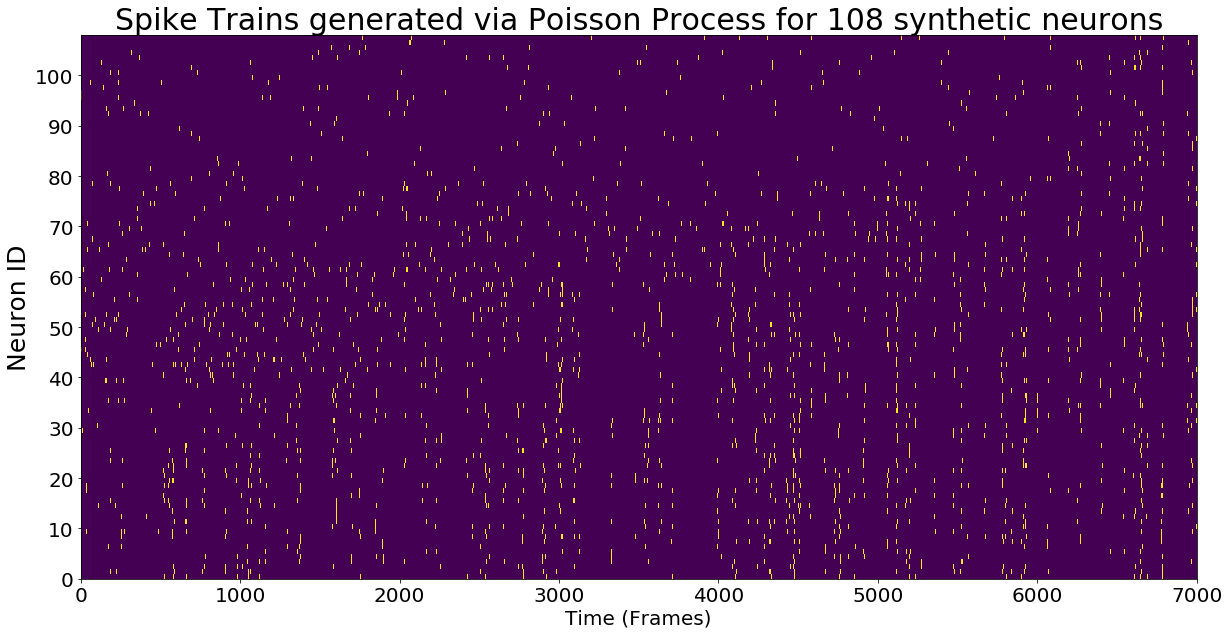

In [227]:
layers = 7
standard_dev = 1.2
window_size = 1000
spike_rate = [int(abs(np.random.normal(20,8))) for i in range(layers)]# spike rate per commiunity
comm_size = [int(np.random.power(3/2)*30) for i in range(layers)]
num_neurons = sum(comm_size)
spikes = create_time_series('grow', comm_size, spike_rate)

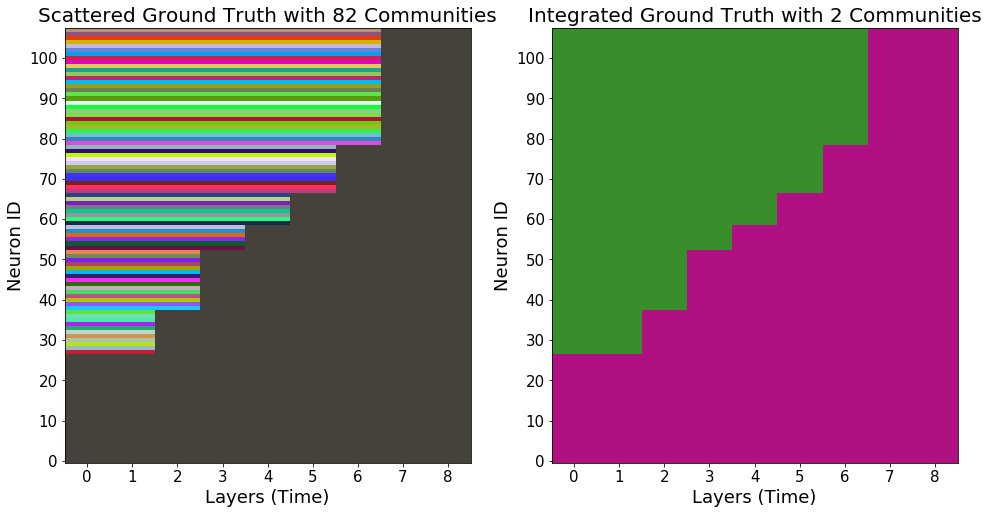

In [228]:
display_truth(comm_size, 'grow')

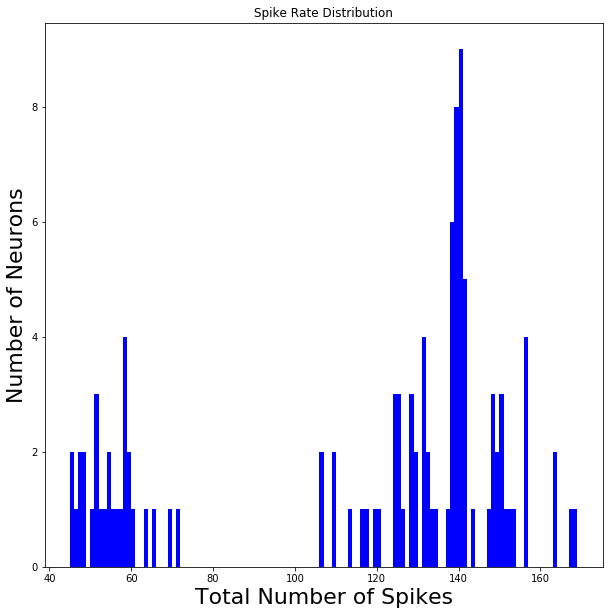

In [229]:
fig,ax = plt.subplots(1,1,figsize= (10,10))
n,bins = spike_count(spikes, ax)

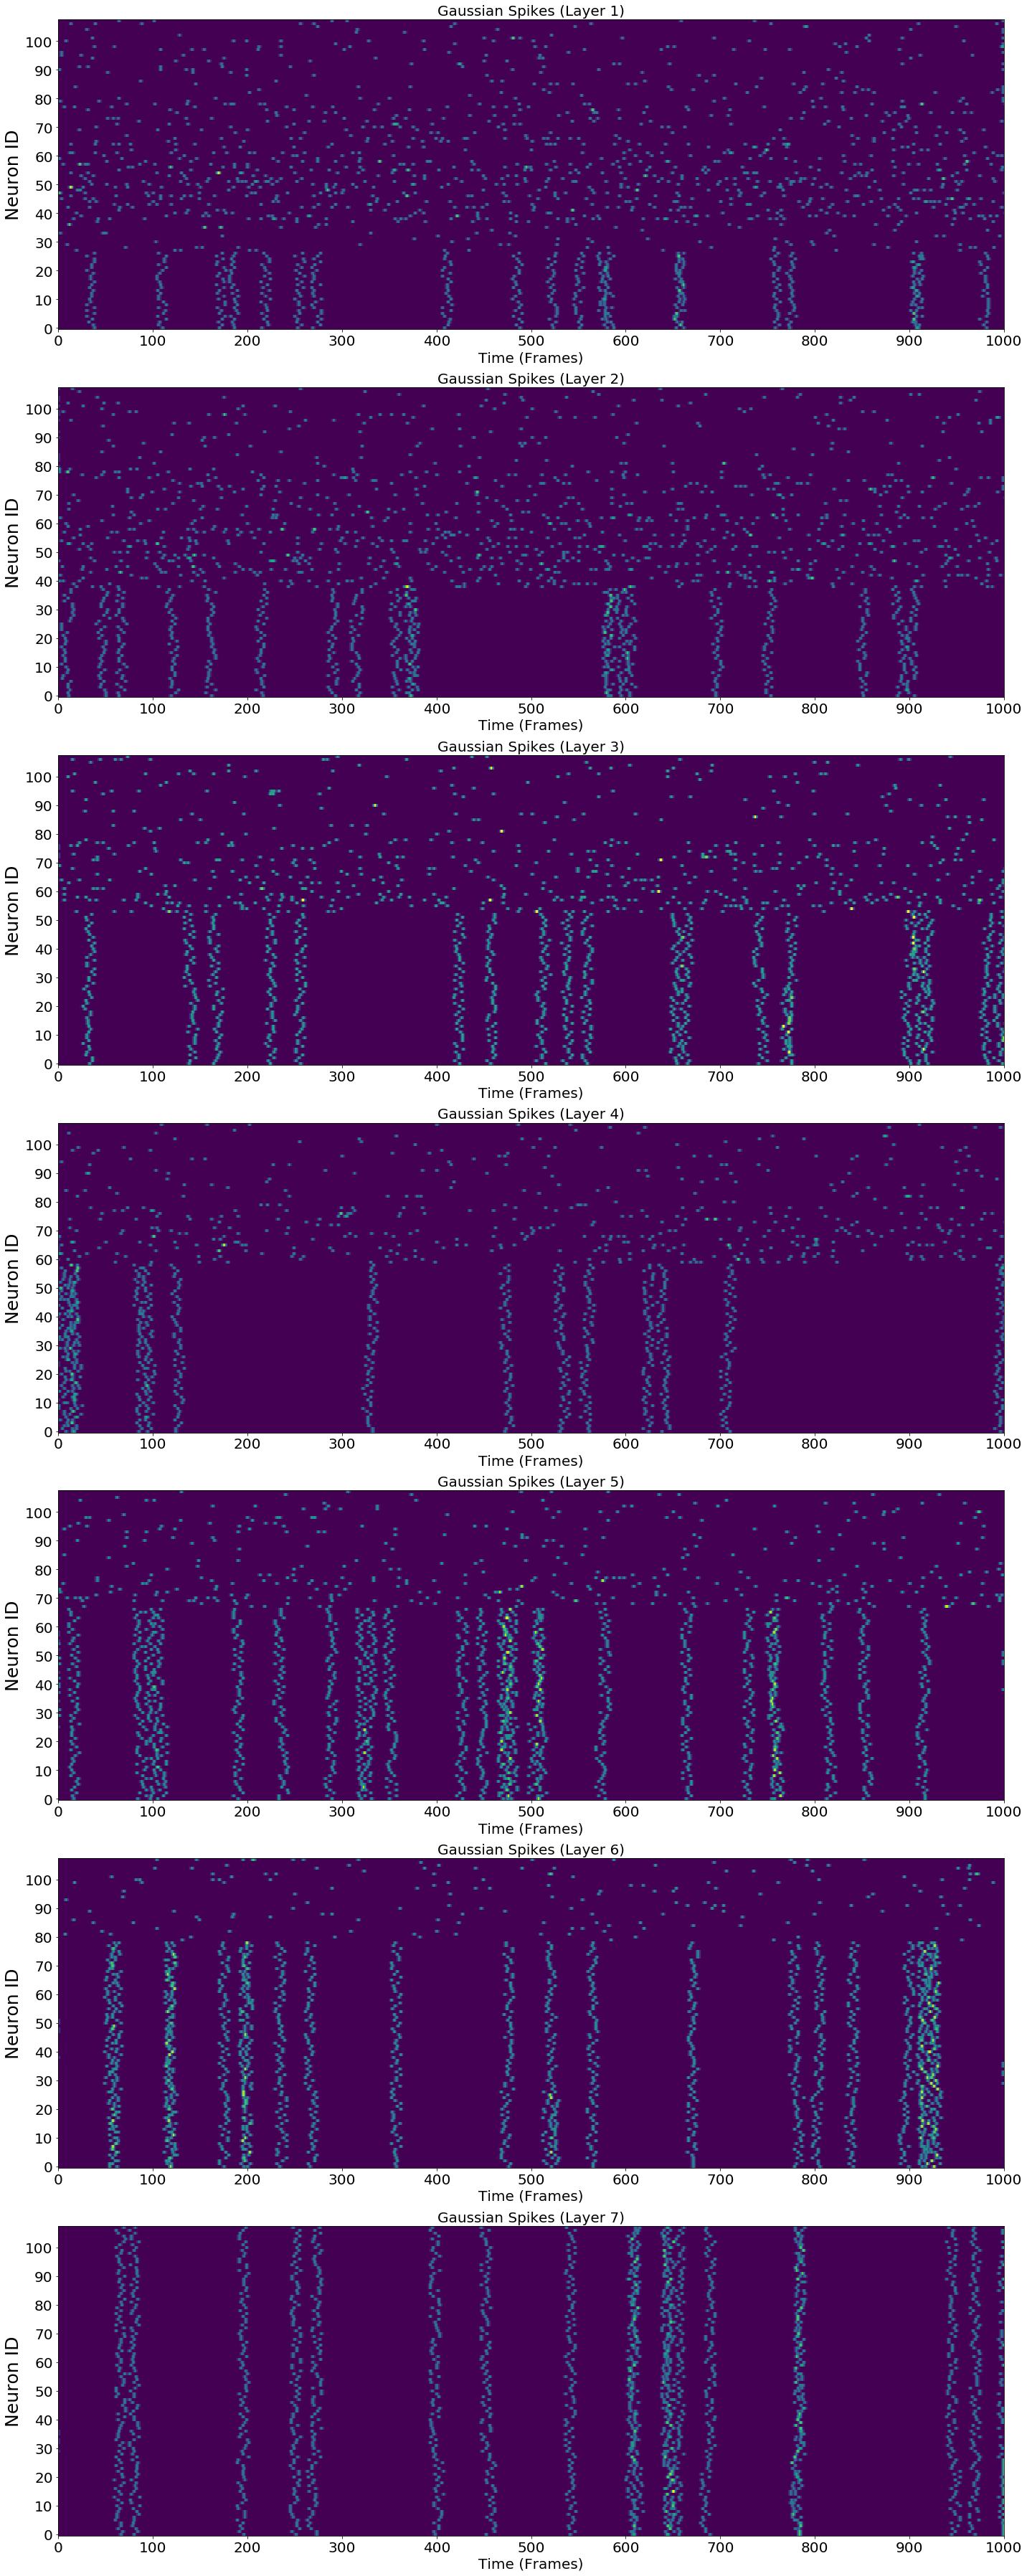

In [230]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(20,50))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()

In [231]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

padded_adjacencies = [adjacency_matrices[0]]  + adjacency_matrices + [adjacency_matrices[-1]]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


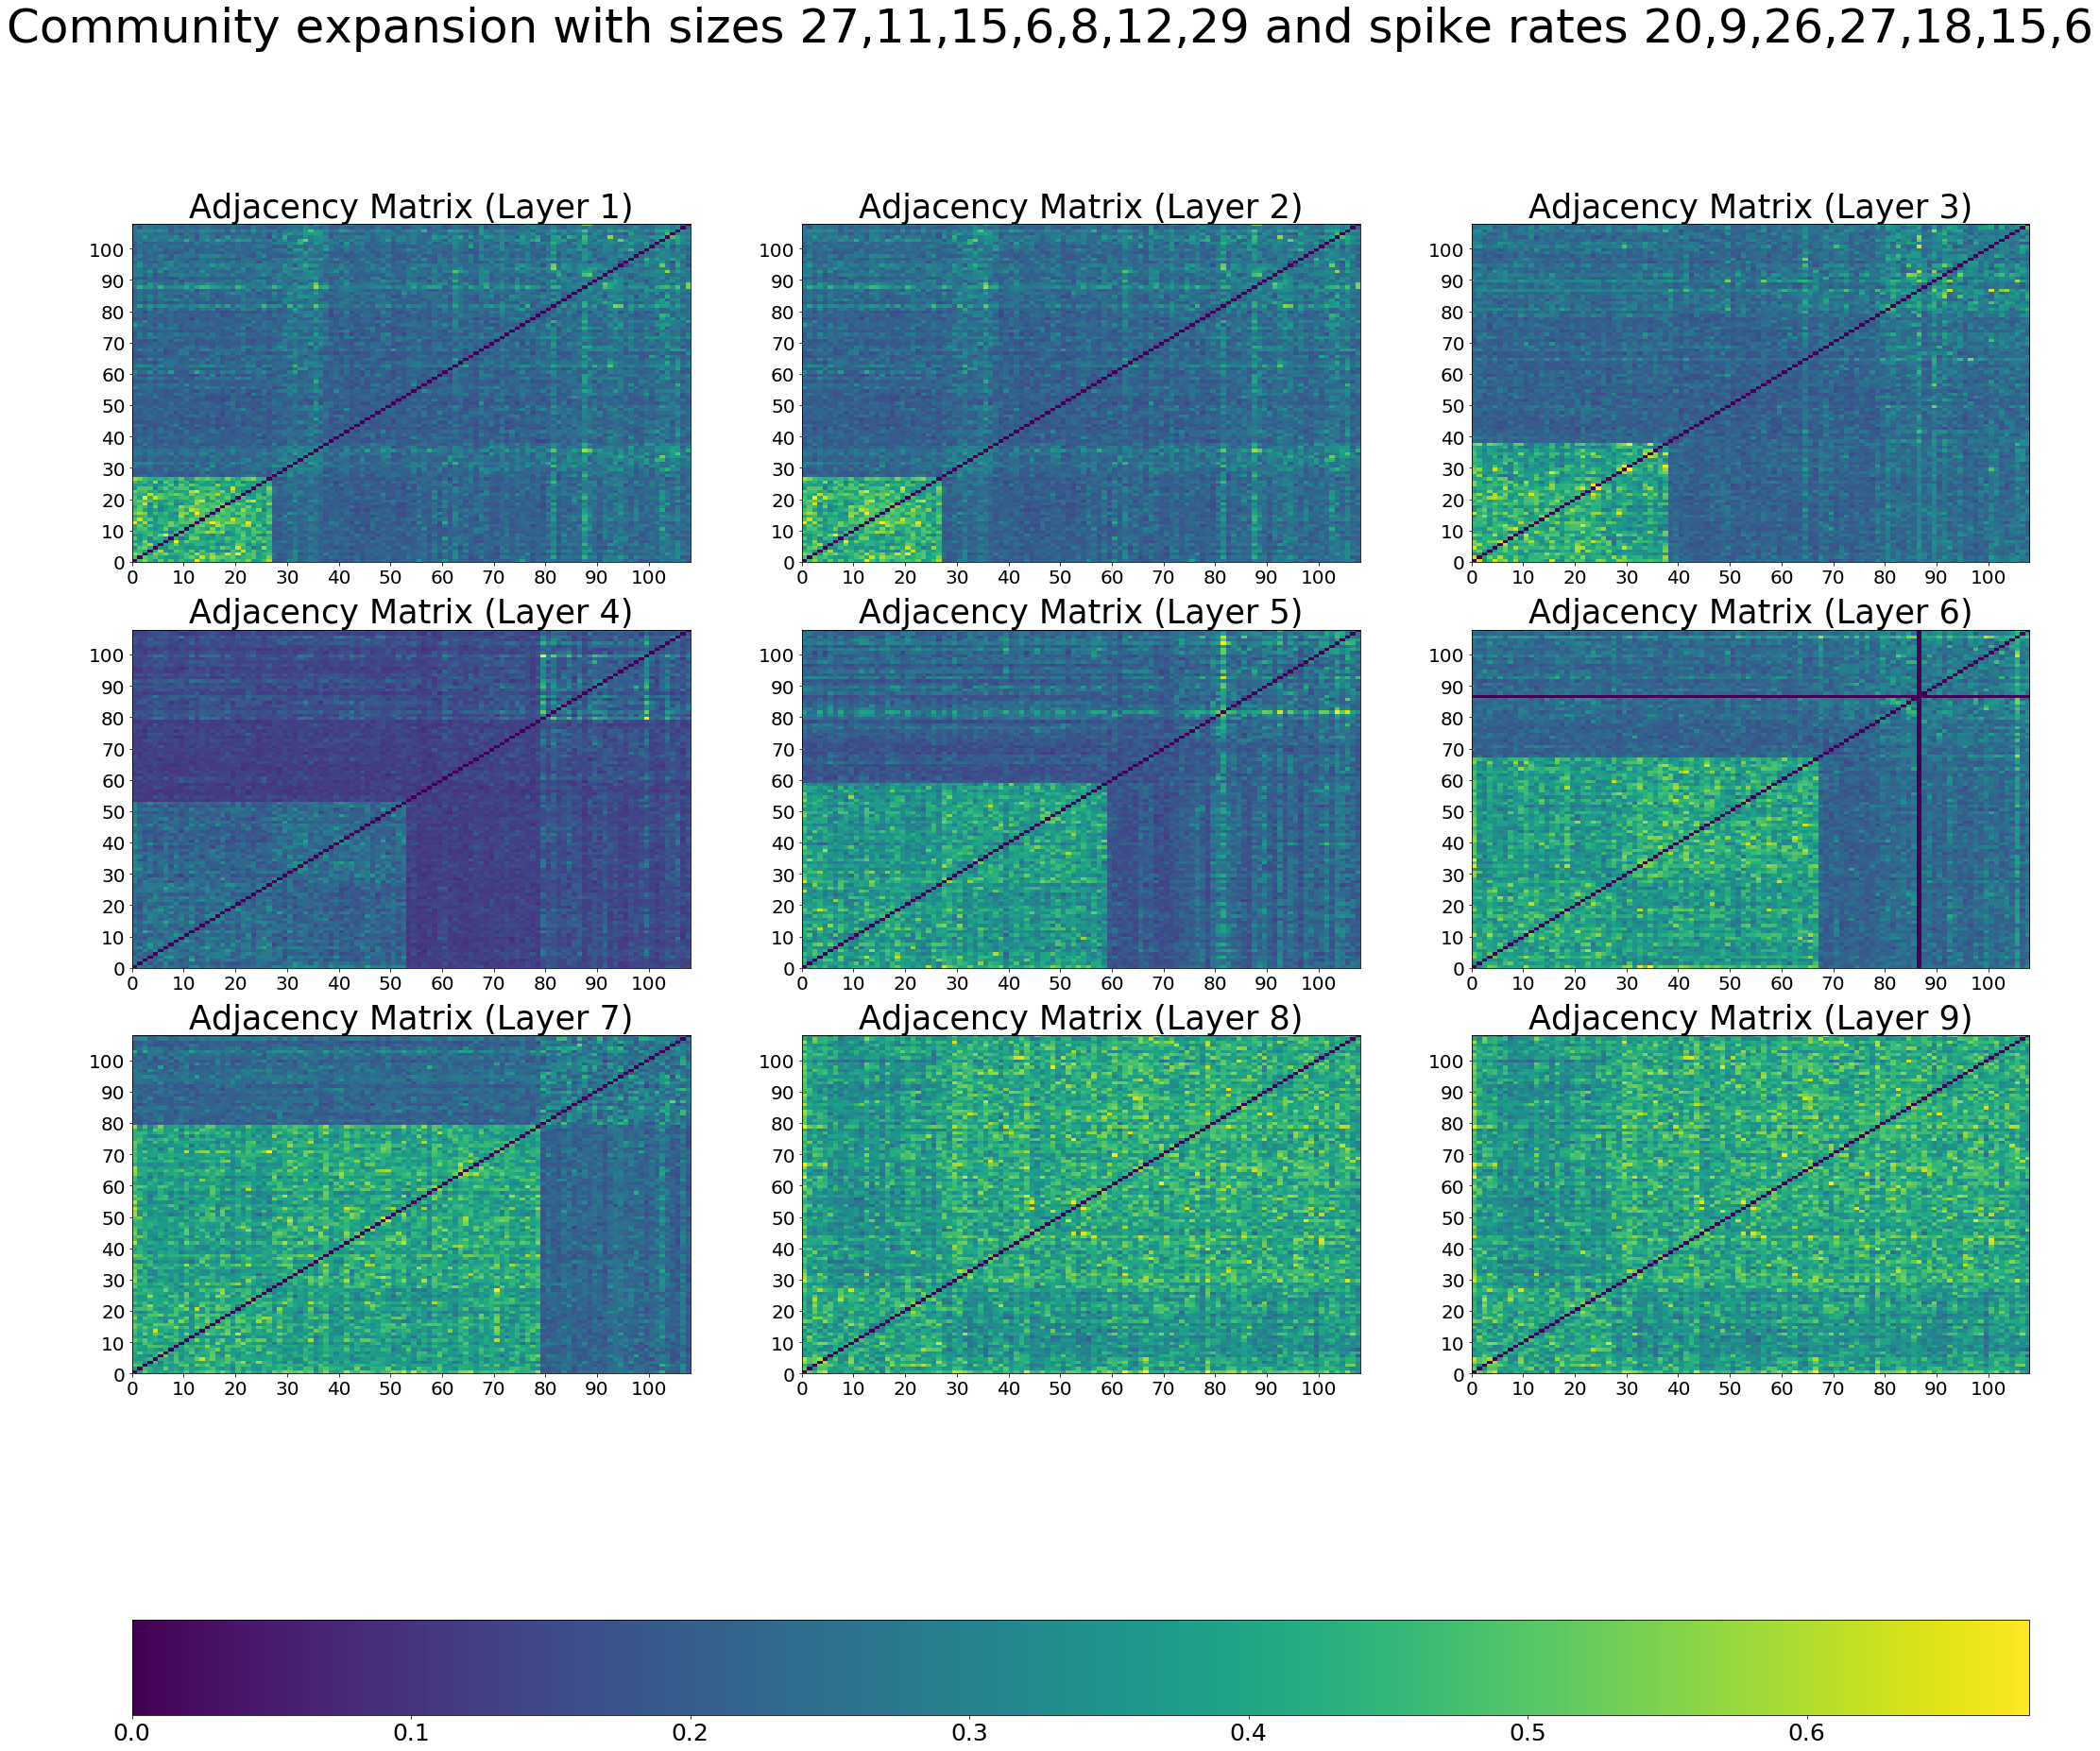

In [232]:
fig,ax = plt.subplots(3, 3, figsize = (36,32))
for i in range(3):
    for j in range(3):
        k = ax[i][j].imshow(padded_adjacencies[i*3+j], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
        ax[i][j].set_title('Adjacency Matrix (Layer %d)'%(i*3+j +1), fontsize = 35)
        ax[i][j].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
fig.suptitle('Community expansion with sizes %d,%d,%d,%d,%d,%d,%d and spike rates %d,%d,%d,%d,%d,%d,%d'%(comm_size[0],comm_size[1],comm_size[2],comm_size[3],comm_size[4],comm_size[5],comm_size[6],spike_rate[0],spike_rate[1],spike_rate[2],spike_rate[3],spike_rate[4],spike_rate[5],spike_rate[6]), fontsize = 50)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 

In [233]:
fixed_size = int(abs(np.random.normal(30,10)))
fixed_rate = int(abs(np.random.normal(20,8)))
fixed_rate1 = int(abs(np.random.normal(20,8)))# spike rate per commiunity
comms = 6

comm_sizes = [[fixed_size for i in range(comms)], #layer1 community sizes
              [3*fixed_size,fixed_size,2*fixed_size]] #layer2 community sizes
spike_rate = [[fixed_rate for i in range(comms)],#spikerates of the respective communities in layer5
              [fixed_rate1, fixed_rate1, fixed_rate1]]#spikerates of the respective communities in layer6

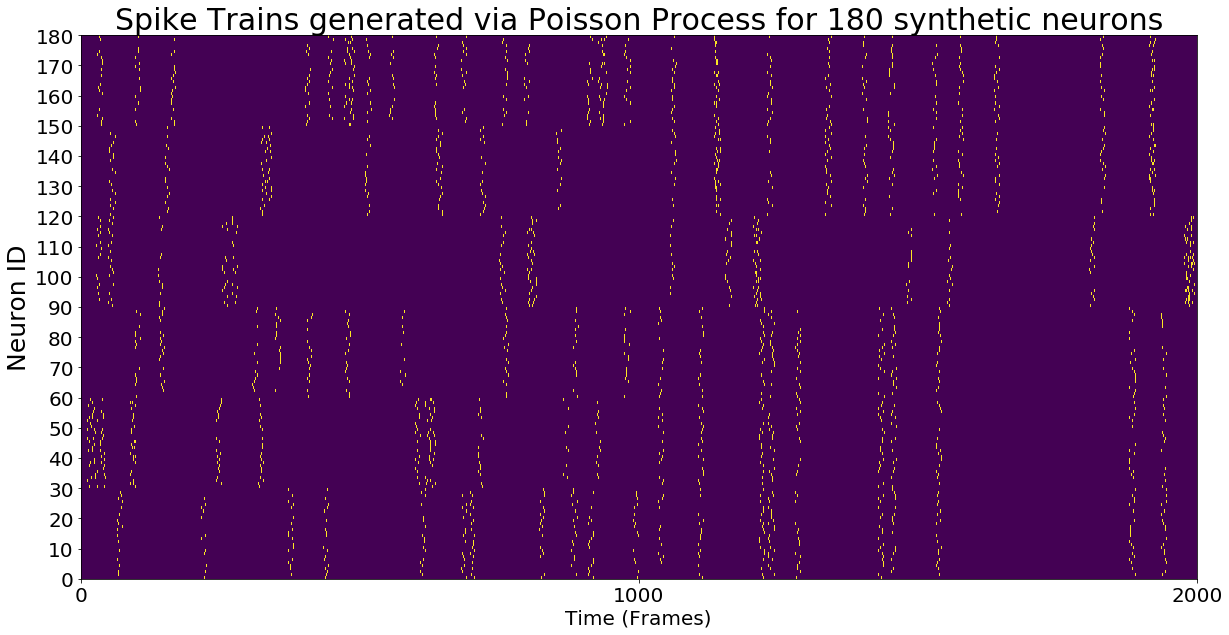

In [234]:
spikes = create_time_series('merge', comm_sizes, spike_rate)

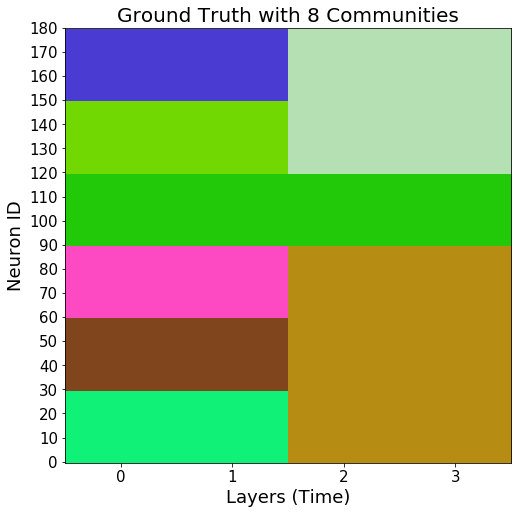

In [235]:
display_truth(comm_sizes, 'merge')

In [236]:
k = [23, [34,3245,56]]
len(k)

2